In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from tqdm.notebook import tqdm
from pathlib import Path
import zipfile
import tarfile
import nibabel as nib

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets,models,transforms
from torchvision.utils import make_grid

In [3]:
zip_file = zipfile.ZipFile(file = "/content/drive/MyDrive/PyTorch_Vol3/06-Atrium-Segmentation.zip",mode = "r")
zip_file.extractall()
zip_file.close()

In [ ]:
!tar -xvf /content/drive/MyDrive/PyTorch_Vol3/Task02_Heart.tar

In [5]:
root = Path("/content/Task02_Heart/imagesTr")
label = Path("/content/Task02_Heart/labelsTr")

In [6]:
list(root.parts)

['/', 'content', 'Task02_Heart', 'imagesTr']

In [7]:
parts = list(root.parts)
parts.index("imagesTr"),parts[2]

(3, 'Task02_Heart')

In [8]:
def change_img_to_label_path(path):
    parts = list(path.parts)
    parts[parts.index("imagesTr")] = "labelsTr"
    return Path(*parts)

In [9]:
change_img_to_label_path(root),root

(PosixPath('/content/Task02_Heart/labelsTr'),
 PosixPath('/content/Task02_Heart/imagesTr'))

In [10]:
sample_path = list(root.glob("la*"))[0]
sample_path

PosixPath('/content/Task02_Heart/imagesTr/la_022.nii.gz')

In [11]:
sample_path_label = change_img_to_label_path(sample_path)
sample_path,sample_path_label

(PosixPath('/content/Task02_Heart/imagesTr/la_022.nii.gz'),
 PosixPath('/content/Task02_Heart/labelsTr/la_022.nii.gz'))

In [12]:
data = nib.load(sample_path)
label = nib.load(sample_path_label)

mri = data.get_fdata()
mask = label.get_fdata().astype(np.uint8)

In [13]:
nib.aff2axcodes(data.affine)

('R', 'A', 'S')

In [14]:
#!pip install celluloid 
from celluloid import Camera
from IPython.display import HTML

from warnings import filterwarnings
filterwarnings("ignore")

In [15]:
mri.shape,mask.shape

((320, 320, 110), (320, 320, 110))

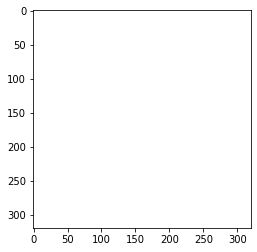

In [16]:
fig = plt.figure()
camera = Camera(fig)

for i in range(mri.shape[2]):
    plt.imshow(mri[:, :, i], cmap = "bone")
    mask_ = np.ma.masked_where(mask[:, :, i] == 0, mask[:, :, i])
    plt.imshow(mask_,alpha = 0.5)
    camera.snap()

animation = camera.animate()

In [17]:
HTML(animation.to_html5_video())

In [18]:
def normalize(full_volume):
    mu = full_volume.mean()
    std = np.std(full_volume)
    normalized = (full_volume - mu) / std
    return normalized

def standardize(normalized):
    standardized = (normalized - normalized.min()) / (normalized.max() - normalized.min())
    return standardized

In [19]:
all_files = list(root.glob("*"))
len(all_files)

21

In [20]:
all_files.pop(4)

PosixPath('/content/Task02_Heart/imagesTr/._la_029.nii.gz')

In [21]:
len(all_files)

20

In [22]:
deneme = nib.load(all_files[0]).get_fdata()
deneme.shape,deneme[32:-32,32:-32].shape

((320, 320, 110), (256, 256, 110))

In [23]:
save_root = Path("Preprocessed")

for counter, path_to_mri_data in enumerate(tqdm(all_files)):

    path_to_label = change_img_to_label_path(path_to_mri_data)

    mri = nib.load(path_to_mri_data)
    assert nib.aff2axcodes(mri.affine) == ("R","A","S") 
    mri_data = mri.get_fdata()
    label_data = nib.load(path_to_label).get_fdata().astype(np.uint8)

    mri_data = mri_data[32:-32, 32:-32]
    label_data =label_data[32:-32, 32:-32]

    normalized_mri_data = normalize(mri_data)
    standardized_mri_data = standardize(normalized_mri_data)

    if counter < 17:
        current_path = save_root/"train"/str(counter)
    else:
        current_path = save_root/"val"/str(counter)

    for i in range(standardized_mri_data.shape[-1]):
        
        slice = standardized_mri_data[:,:,i]
        mask = label_data[:,:, i]
        
        slice_path = current_path/"data"
        mask_path = current_path/"masks"
        
        slice_path.mkdir(parents = True, exist_ok = True)
        mask_path.mkdir(parents = True, exist_ok = True)

        np.save(slice_path/str(i), slice)
        np.save(mask_path/str(i), mask)

  0%|          | 0/20 [00:00<?, ?it/s]

In [24]:
path = Path("Preprocessed/train/0")
path

PosixPath('Preprocessed/train/0')

In [25]:
file = "50.npy"
slice = np.load(path/"data"/file)
mask = np.load(path/"masks"/file)

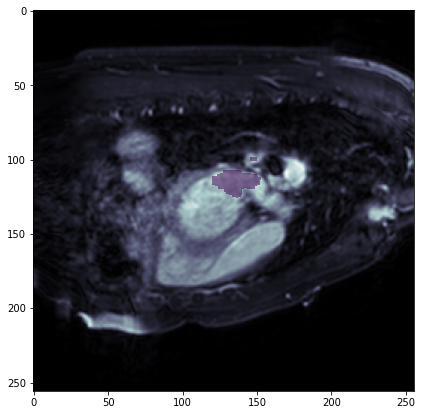

In [26]:
plt.figure(figsize = (7,7))
plt.imshow(slice, cmap = "bone")
mask_ = np.ma.masked_where(mask == 0 , mask)
plt.imshow(mask_, alpha = .5)
plt.show()

---

In [28]:
import imgaug
imgaug.__version__

'0.4.0'

In [29]:
#!pip install imgaug==0.4.0
import imgaug
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from IPython.core.pylabtools import select_figure_formats

In [37]:
class CardiacDataset(torch.utils.data.Dataset):

    def __init__(self, root, augment_params):
        self.all_files = self.extract_files(root)
        self.augment_params = augment_params

    @staticmethod
    def extract_files(root):
        files = []
        for subject in root.glob("*"):
            slice_path = subject/"data"
            for slice in slice_path.glob("*.npy"):
                files.append(slice)
        return files

    @staticmethod
    def change_img_to_label_path(path):

        parts = list(path.parts)
        parts[parts.index("data")] = "masks"
        return Path(*parts)

    def augment(self, slice, mask):
        random_seed = torch.randint(0,100000, (1,)).item()
        imgaug.seed(random_seed)

        mask = SegmentationMapsOnImage(mask, mask.shape)
        slice_aug, mask_aug = self.augment_params(image = slice, segmentation_maps = mask)
        mask_aug = mask_aug.get_arr()
        return slice_aug, mask_aug

    def __len__(self):
        return len(self.all_files)
    
    def __getitem__(self,idx):
        file_path = self.all_files[idx]
        mask_path = self.change_img_to_label_path(file_path)
        
        slice = np.load(file_path).astype(np.float32)
        mask = np.load(mask_path)

        if self.augment_params:
            slice, mask = self.augment(slice, mask)
        return np.expand_dims(slice,0), np.expand_dims(mask,0)

In [38]:
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa

In [39]:
seq = iaa.Sequential([
                      iaa.Affine(
                          scale = (0.85, 1.15),
                          rotate = (-45,45)
                     ),
                      iaa.ElasticTransformation()
])

In [40]:
path = Path("/content/Preprocessed/train")
dataset = CardiacDataset(path, seq)

In [41]:
len(dataset)

1941

In [46]:
dataset[1][0].shape,dataset[1][1].shape

((1, 256, 256), (1, 256, 256))

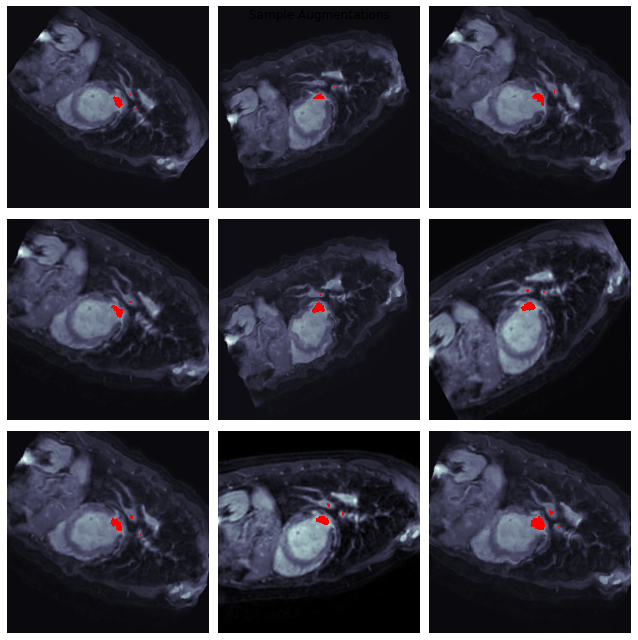

In [44]:
fig ,axis = plt.subplots(3,3,figsize = (9,9))

axis = axis.ravel()

for i in range(len(axis)):

    slice,mask = dataset[1]
    mask_ = np.ma.masked_where(mask == 0, mask)
    axis[i].imshow(slice[0], cmap = "bone")
    axis[i].imshow(mask_[0], cmap = "autumn")
    axis[i].axis("off")

fig.suptitle("Sample Augmentations")
plt.tight_layout()
plt.show()

---

In [47]:
import torch

In [51]:
class DoubleConv(torch.nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.step = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, 3, padding = 1),
                                        torch.nn.ReLU(),
                                        torch.nn.Conv2d(out_channels, out_channels, 3, padding = 1),
                                        torch.nn.ReLU())
        
    def forward(self,X):
        return self.step(X)

In [64]:
class UNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = DoubleConv(1,64)
        self.layer2 = DoubleConv(64, 128)
        self.layer3 = DoubleConv(128, 256)
        self.layer4 = DoubleConv(256, 512)

        self.layer5 = DoubleConv(512+256,256)
        self.layer6 = DoubleConv(256+128,128)
        self.layer7 = DoubleConv(128+64,64)
        self.layer8 = torch.nn.Conv2d(64,1,1)

        self.maxpool = torch.nn.MaxPool2d(2)

    def forward(self,x):

        x1 = self.layer1(x) 
        x1m = self.maxpool(x1) 
 
        x2 = self.layer2(x1m)
        x2m = self.maxpool(x2)

        x3 = self.layer3(x2m)
        x3m = self.maxpool(x3)

        x4 = self.layer4(x3m)

        x5 = torch.nn.Upsample(scale_factor = 2, mode = "bilinear")(x4)
        x5 = torch.cat([x5,x3], dim = 1)
        x5 = self.layer5(x5)

        x6 = torch.nn.Upsample(scale_factor = 2, mode = "bilinear")(x5)
        x6 = torch.cat([x6,x2], dim = 1)
        x6 = self.layer6(x6)

        x7 = torch.nn.Upsample(scale_factor = 2, mode = "bilinear")(x6)
        x7 = torch.cat([x7,x1], dim = 1)
        x7 = self.layer7(x7)

        ret = self.layer8(x7)
        return ret

In [75]:
input = torch.randn(1,1,256,256)
input.shape

torch.Size([1, 1, 256, 256])

In [79]:
torch.nn.MaxPool2d(2)(input).shape

torch.Size([1, 1, 128, 128])

In [78]:
torch.nn.Upsample(scale_factor = 2, mode = "bilinear")(input).shape

torch.Size([1, 1, 512, 512])

In [ ]:
model = UNet()
for param in model.parameters():
    print(param.shape)

In [ ]:
model

In [66]:
random_input = torch.randn(1,1,256,256)
output = model(random_input)
assert output.shape == torch.Size([1,1,256,256])

---

In [81]:
#!pip install pytorch-lightning
#!pip install torchmetrics 

In [84]:
from pathlib import Path
import numpy as np

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import imgaug
import imgaug.augmenters as iaa

In [85]:
seq = iaa.Sequential([
                      iaa.Affine(scale = (0.85, 1.15),
                                 rotate = (-45,45)),
                      iaa.ElasticTransformation()
])

In [86]:
train_path = Path("/content/Preprocessed/train/")
val_path = Path("/content/Preprocessed/val/")

train_dataset = CardiacDataset(train_path, seq)
val_dataset = CardiacDataset(val_path,None)

In [87]:
batch_size = 8
num_workers = 4

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, 
                                           num_workers = num_workers, shuffle = True)


val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, 
                                           num_workers = num_workers, shuffle = False)


In [88]:
class DiceLoss(torch.nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self,pred,mask):

        pred = torch.flatten(pred)
        mask = torch.flatten(mask)

        counter = (pred*mask).sum()
        denum = pred.sum() + mask.sum() + 1e-8
        dice = (2*counter) / denum

        return 1-dice

In [89]:
class AtriumSegmentation(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.model = UNet()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = 1e-4)
        self.loss_fn = DiceLoss()

    def forward(self,data):
        return torch.sigmoid(self.model(data))

    def training_step(self,batch,batch_idx):
        mri, mask = batch
        mask = mask.float()
        pred = self(mri)

        loss = self.loss_fn(pred, mask)

        self.log("Train Dice", loss)
        
        if batch_idx % 50 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), "Train")

        return loss

    def validation_step(self,batch,batch_idx):
        mri, mask = batch
        mask = mask.float()
        pred = self(mri)

        loss = self.loss_fn(pred, mask)

        self.log("Val Dice", loss)
        
        if batch_idx % 2 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), "Val")

        return loss

    def log_images(self, mri, pred, mask, name):

        pred = pred > 0.5

        fig, axis = plt.subplots(1,2 ,figsize = (12,12))
        axis[0].imshow(mri[0][0], cmap = "bone")
        mask_ = np.ma.masked_where(mask[0][0] == 0 , mask[0][0])
        axis[0].imshow(mask_, alpha = 0.6)

        axis[1].imshow(mri[0][0], cmap = "bone")
        mask_ = np.ma.masked_where(mask[0][0] == 0 , mask[0][0])
        axis[1].imshow(mask_, alpha = 0.6)

        self.logger.experiment.add_figure(name, fig, self.global_step)

    def configure_optimizers(self):
        return [self.optimizer]

In [90]:
torch.manual_seed(0)
model = AtriumSegmentation()

In [91]:
checkpoint_callback = ModelCheckpoint(monitor="Val Dice", save_top_k = 10, mode = "min")

In [92]:
gpus = 0
trainer = pl.Trainer(gpus = gpus, logger = TensorBoardLogger(save_dir = "/content/logs"), 
                     log_every_n_steps = 1, callbacks = checkpoint_callback, max_epochs = 75)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [93]:
#trainer.fit(model, train_loader, val_loader)

Missing logger folder: /content/logs/default

  | Name    | Type     | Params
-------------------------------------
0 | model   | UNet     | 7.8 M 
1 | loss_fn | DiceLoss | 0     
-------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.127    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

---

In [94]:
import nibabel as nib
from tqdm.notebook import tqdm
from celluloid import Camera

In [95]:
model = AtriumSegmentation.load_from_checkpoint("/content/06-Atrium-Segmentation/weights/70.ckpt")

In [96]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval();
model.to(device)

AtriumSegmentation(
  (model): UNet(
    (layer1): DoubleConv(
      (step): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (layer2): DoubleConv(
      (step): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (layer3): DoubleConv(
      (step): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (layer4): DoubleConv(
      (step): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2):

In [97]:
preds = []
labels = []

for slice, label in tqdm(val_dataset):
    slice = torch.tensor(slice).to(device).unsqueeze(0)
    with torch.no_grad():
        pred = model(slice)

    preds.append(pred.cpu().numpy())
    labels.append(label)

  0%|          | 0/330 [00:00<?, ?it/s]

In [99]:
preds = np.array(preds)
labels = np.array(labels)

In [100]:
1 - model.loss_fn(torch.from_numpy(preds), torch.from_numpy(labels))

tensor(0.9501)

In [101]:
subject = "/content/Task02_Heart/imagesTs/la_002.nii.gz"
subject_mri = nib.load(subject).get_fdata()

In [102]:
subject_mri = subject_mri[32 : -32, 32:-32]
standardized_scan = standardize(normalize(subject_mri))

In [108]:
preds = []
for i in range(standardized_scan.shape[-1]):

    slice = standardized_scan[:, :, i]
    with torch.no_grad():
        pred = model(torch.tensor(slice).unsqueeze(0).unsqueeze(0).float().to(device))[0][0]
        pred = pred > 0.5

    preds.append(pred.cpu())

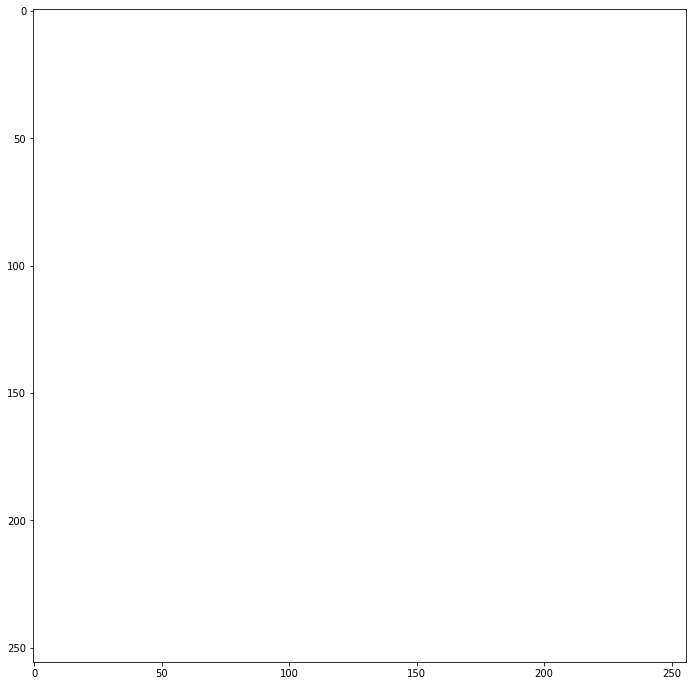

In [109]:
fig = plt.figure(figsize = (12,12))
camera = Camera(fig)

for i in range(standardized_scan.shape[-1]):
    plt.imshow(standardized_scan[:, :, i], cmap = "bone")
    mask = np.ma.masked_where(preds[i] == 0, preds[i])
    plt.imshow(mask, alpha = 0.5)
    camera.snap()

animation = camera.animate()

In [110]:
HTML(animation.to_html5_video())

Output hidden; open in https://colab.research.google.com to view.